In [1]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
import timeit 
import requests
import rtree
###MGGG's processing:
#X Precinct shapefile: Louisiana House of Representative, 2018
#**** Election data: Louisiana Secretary of State
#X Demographic data: 2010 Decennial Census (via API)
#X Demographic data geography: 2010 Census blocks (via TIGER/Line Shapefiles)

#"Some merging of precincts in the tabular election data and precinct 
# shapefile were necessary to join election results for multiple years 
# onto 2018 precinct boundaries. Data from early and absentee votes 
# reported at the parish level were disaggregated by voting age 
# population. Demographic data were aggregated from the block level 
# using MGGG’s proration software. Congressional and state legislative 
#district IDs were also assigned to precincts using this package.

In [2]:
#Start a timer
start = timeit.default_timer()

In [3]:
#Download MGGG's CVAP data as a csv
print('https://raw.githubusercontent.com/mggg-states/LA-shapefiles/main/LA-1519-cvap.csv')
req=requests.get('https://raw.githubusercontent.com/mggg-states/LA-shapefiles/main/LA-1519-cvap.csv')
url_content = req.content
csv_file= open('./mggg-la-final/LA-1519-cvap.csv','wb')
csv_file.write(url_content)
csv_file.close()

https://raw.githubusercontent.com/mggg-states/LA-shapefiles/main/LA-1519-cvap.csv


In [4]:
pd.read_csv('./mggg-la-final/LA-1519-cvap.csv')

,GEOID10,State,STATEFP,COUNTYFP,County,Precinct,Code,TOTPOP,NH_WHITE,NH_BLACK,...,NHPICVAP16,NHPICVAP17,NHPICVAP18,WCVAP12,WCVAP13,WCVAP14,WCVAP15,WCVAP16,WCVAP17,WCVAP18
0,220051,Louisiana,22,5,Ascension,00 01 A,"Ascension, 00 01 A",2887,2321,325,...,0.0,0.0,0.0,1460.366175,1618.447050,1668.631454,1688.705216,1741.398841,1663.613014,1947.154900
1,220052,Louisiana,22,5,Ascension,00 02 A,"Ascension, 00 02 A",2617,2374,109,...,0.0,0.0,0.0,1830.000000,1750.000000,1870.000000,2000.000000,1780.000000,1875.000000,1675.000000
2,220053,Louisiana,22,5,Ascension,00 03,"Ascension, 00 03",2238,1966,139,...,0.0,0.0,0.0,1375.000000,1365.000000,1320.000000,1770.000000,1790.000000,1890.000000,1770.000000
3,220054,Louisiana,22,5,Ascension,00 04,"Ascension, 00 04",1695,1346,216,...,0.0,0.0,0.0,1191.244703,1256.340042,1210.773305,1119.639831,1106.620763,1204.263771,1230.301907
4,220055,Louisiana,22,5,Ascension,00 05,"Ascension, 00 05",2119,1605,300,...,0.0,0.0,0.0,1367.576346,1270.851634,1405.983245,1197.052243,1230.845252,1230.238856,1497.366391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689,221277-1,Louisiana,22,127,Winn,07 1,"Winn, 07 1",329,187,118,...,0.0,0.0,0.0,117.509931,134.317618,131.443933,119.437245,112.015742,115.507885,118.128390
3690,221277-1A,Louisiana,22,127,Winn,07 1A,"Winn, 07 1A",280,266,14,...,0.0,0.0,0.0,148.964374,149.915991,142.257046,142.152312,167.840426,157.508120,144.559330
3691,221277-2,Louisiana,22,127,Winn,07 2,"Winn, 07 2",415,412,2,...,0.0,0.0,0.0,361.713031,259.004392,247.840410,265.702782,234.443631,187.554905,183.089312
3692,221277-2A,Louisiana,22,127,Winn,07 2A,"Winn, 07 2A",716,604,94,...,0.0,0.0,0.0,390.779201,351.601931,421.672983,415.507864,437.972041,456.599446,469.860743


**Load data**

Retrieve demographic data from Census API

To see the full list of census variables, look here: https://api.census.gov/data/2010/dec/sf1/variables.html


In [5]:
# Code chunk by Melisande Teng - VRDI 2019
## SN creates an array of interested variables
variables = [
    # pop
    "P005001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013", 
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]
## creates array of the descirptions of those variables, in order
keys = [
    # pop
    "TOTPOP",  # these follow from above, so TOTPOP = P005001
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN",
    "NH_ASIAN",
    "NH_NHPI",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",#add above
    "H_BLACK",##
    "H_AMIN", ##
    "H_ASIAN",##
    "H_NHPI",##
    "H_OTHER",##
    "H_2MORE",##add
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]

import requests

#function to retrieve these variables at the county level, from the 2010 Decennial Census
def counties(state_fips):
    """Inputs: state fips code
    Process: Retrieves a list of counties in the given state from the Census API.  
    Outputs: A list of county fips codes in the state. """
    #uses the fips input into the census api
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)  #uses the fips input to locate the state
    )
    #retrieves the data as a json 
    header, *rows = resp.json()
    #county column is "county"
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows) #sequence of counties 
    return county_fips_codes  #returns the fips codes of all counties

#function that inputs the state fips, the countyfips and default variables and keys from above
def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    """Inputs: state fips code, county fips code, list of variables and corresponding keys. 
    Process: formats the query to call the Census API. 
    Outputs: data for the county in a pandas dataframe. """
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables)) #joins the variables to extract in API
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips) #in state and county
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys)) #creates dictionary for the variables and keys
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]  #names the headers 
    dtypes = {key: int for key in keys} #changes all data to integers
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})  #changes these data types string
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes) #makes a pandas dataframe using rows and the columns variable, set as the dtypes 
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"] # new variable for geoid that sums all of the unique geographies to create GEOID
    return data


def block_data_for_state(state_fips):
    """Input: state_fips
    Process: Retrieve a list of county fips codes in the state. 
        The Census API only lets you query one county at a time, so you first need the full list. 
        Then call block_data_for_county() to retrieve the data at the county level. 
    Outputs: block-level data for the state fips for the list of variables defined above. 
    """
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [6]:
# Retrieve the block level data for the state
la_demo = block_data_for_state('22')

In [7]:
la_demo = la_demo.rename(columns={"geoid": "GEOID10"})
la_demo.to_csv('la_demo_census_2010_blocks.csv')

Example of how you would write the census data to a csv and then re-load it so you don't have to query it every time you re-run this script. 

In [8]:
la_demo = pd.read_csv('la_demo_census_2010_blocks.csv')
blocks = la_demo.astype({"GEOID10": str})
blocks.head(2)

,Unnamed: 0,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,GEOID10
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,"Block 1020, Block Group 1, Census Tract 104, B...",22,15,10400,1020,220150104001020
1,1,47,16,16,0,0,0,0,8,7,...,0,0,0,7,"Block 1034, Block Group 1, Census Tract 104, B...",22,15,10400,1034,220150104001034


These files are accessible in S3, or temporarily on github for the purpose of the demo. Make sure to unzip the files so that these are accessible to read them in as geopandas dataframes.


In [9]:
##Extract blocks via TigerWeb API



In [10]:
#blocks = pd.read_csv("./raw-from-source/demographic_data/nhgis_ds172_2010_block.csv") #census data we queried above

# Block shapefile also retrieved separately from the census
block_shp = gp.read_file("./raw-data/tl_2010_22_tabblock10/tl_2010_22_tabblock10.shp")


In [11]:
# Precinct shapefile retrieved from the Louisiana House of Representatives
precincts = gp.read_file("./raw-data/2018_precincts/2018 LA Precincts for the Web.shp")

**set shapefile projections**

Confirm the projection of the precinct shapefile, as documented here: https://github.com/mggg-states/VA-shapefiles

CRS = coordinate reference system


In [12]:
precincts.crs

<Geographic 2D CRS: EPSG:4019>
Name: Unknown datum based upon the GRS 1980 ellipsoid
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Not specified
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: Not specified (based on GRS 1980 ellipsoid)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
proj = precincts.crs

Project the block shapefile and precincts to NAD83, saved above


In [14]:
precincts = precincts.to_crs(proj)
block_shp = block_shp.to_crs(proj)

In [15]:
final = gp.read_file('./MGGG-la-final/LA_1519/LA_1519.shp')
dir(gp)

['GeoDataFrame',
 'GeoSeries',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_compat',
 '_config',
 '_vectorized',
 '_version',
 'array',
 'base',
 'clip',
 'datasets',
 'geodataframe',
 'geopandas',
 'geoseries',
 'gpd',
 'io',
 'np',
 'options',
 'overlay',
 'pd',
 'plotting',
 'points_from_xy',
 'read_feather',
 'read_file',
 'read_parquet',
 'read_postgis',
 'show_versions',
 'sindex',
 'sjoin',
 'tools']

In [65]:
proj = final.crs
proj

<Projected CRS: EPSG:6476>
Name: NAD83(2011) / Louisiana North
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - Louisiana - SPCS - N
- bounds: (-94.05, 30.85, -90.86, 33.03)
Coordinate Operation:
- name: SPCS83 Louisiana North zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [66]:
final = final.to_crs(proj)
precincts = precincts.to_crs(proj)

In [134]:
joined = pd.merge(final, precincts, on=['GEOID10'], indicator=True, how='outer')
differing_precincts = joined[joined['_merge'] != 'both']
print('number of differing precincts: ', differing_precincts.shape[0])
differing_precincts_GEOIDs = [differing_precincts['GEOID10']]
print(differing_precincts_GEOIDs)
joined_inner = pd.merge(final, precincts, on=['GEOID10'], how='inner')
final_rows = final.shape[0]
precinct_rows = precincts.shape[0]
print("Number of different rows: ", abs(final_rows-precinct_rows))
print("raw file rows: ", precinct_rows)
print("mggg-la rows: ", final_rows)
print("outer merge test rows: ", joined_outer.shape[0])
#Find where 'State' or 'ID' are empty and return -- these are ones that are different between the two

number of differing precincts:  28
[1277     22051125
1458     220516-K
1473     220517-K
3694     2207352A
3695     2207356A
3696    22051125B
3697       220479
3698    220092-5B
3699    220333-56
3700    220333-55
3701     220896-3
3702     220896-5
3703     220893-6
3704     220892-7
3705     220893-4
3706    22051125A
3707    220516-KA
3708    220516-KB
3709    220517-KB
3710    220517-KA
3711      220637D
3712    22105143A
3713      220731A
3714      2208758
3715      2208755
3716     220752-2
3717     220755-2
3718     220754-2
Name: GEOID10, dtype: object]
Number of different rows:  22
raw file rows:  3716
mggg-la rows:  3694
outer merge test rows:  3719


**Join block-level deomographic data with block-level shapefile**

In [17]:
block_shp.head(2)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,22,001,960400,2067,220019604002067,Block 2067,G5040,R,None,None,S,10663,0,+30.3255454,-092.4905919,"POLYGON ((-92.49005 30.32601, -92.49005 30.325..."
1,22,001,960400,2073,220019604002073,Block 2073,G5040,R,None,None,S,15680,0,+30.3206207,-092.4905579,"POLYGON ((-92.49002 30.31993, -92.49029 30.319..."


Join the block shapefile to the census demographic data on the GEOID


In [18]:
blk_joined = pd.merge(block_shp, blocks, on='GEOID10', how='left', indicator=True)

Check total population - join is good!

In [19]:
blk_joined.TOTPOP.sum()

4533372

In [20]:
blk_joined[['GEOID10','geometry','TOTPOP','NH_WHITE','VAP']].head(10)

,GEOID10,geometry,TOTPOP,NH_WHITE,VAP
0,220019604002067,"POLYGON ((-92.49005 30.32601, -92.49005 30.325...",0,0,0
1,220019604002073,"POLYGON ((-92.49002 30.31993, -92.49029 30.319...",30,29,20
2,220019604002077,"POLYGON ((-92.49102 30.31685, -92.49036 30.316...",5,5,1
3,220019602002026,"POLYGON ((-92.46568 30.45666, -92.46568 30.456...",62,54,46
4,220019603003028,"POLYGON ((-92.56331 30.23613, -92.56818 30.236...",0,0,0
5,220019603002020,"POLYGON ((-92.56514 30.30034, -92.56530 30.300...",26,26,19
6,220019604002099,"POLYGON ((-92.49680 30.33185, -92.49667 30.331...",0,0,0
7,220019603003019,"POLYGON ((-92.60249 30.23649, -92.60301 30.236...",0,0,0
8,220019602002049,"POLYGON ((-92.47516 30.42296, -92.47528 30.422...",4,4,2
9,220019602003017,"POLYGON ((-92.40909 30.39256, -92.40909 30.394...",12,12,6


Make sure the map looks right!

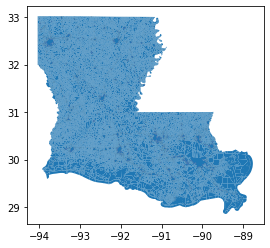

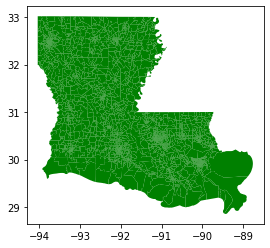

In [21]:
blk_joined.plot()
precincts.plot(color='green')

### Prorate Demographic and Voting Population Data from the Block level to Precincts

In [22]:
proj = blk_joined.crs

This is sometimes necessary in order to get rid of topology errors
Ruth from MGGG recommended this -- not sure exactly what it does but it works, "buffer the geometries with zero distance"


In [23]:
blk_joined["geometry"] = blk_joined.buffer(0)
precincts["geometry"] = precincts.buffer(0)

See MAUP library for details (linked in imports). In short, MAUP assign is mapping every geometry in the census block file to the precinct file. 


In [25]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
             'NH_NHPI', 'NH_OTHER','NH_2MORE', 'HISP', "H_WHITE","H_BLACK",
             "H_AMIN", "H_ASIAN", "H_NHPI", "H_OTHER","H_2MORE",
             'WVAP', 'BVAP', 'AMINVAP','ASIANVAP', 'NHPIVAP', 'OTHERVAP', 
             '2MOREVAP'] 

blk_joined = blk_joined.to_crs(proj)

pieces = maup.assign(blk_joined, precincts)

/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


Sum the census block demo columns within the precincts and assign them to the precinct shapefile


In [26]:
precincts[variables] = blk_joined[variables].groupby(pieces).sum()

Confirm the total population of the precinct shapefile after prorating the census blocks to precincts


In [27]:
precincts.TOTPOP.sum()

4533372

In [28]:
precincts.head()

,ID,AREA,OBJECTID,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,...,H_NHPI,H_OTHER,H_2MORE,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,3162,147.168381,3360,22,111,24,2211124,A,Precinct 24,Precinct 24,...,0,10,4,560,190,5,0,0,0,3
1,2161,239.121475,3396,22,113,23,2211323,A,Precinct 23,Precinct 23,...,0,31,0,844,20,7,1,0,0,8
2,2148,392.914185,3371,22,113,16,2211316,A,Precinct 16,Precinct 16,...,0,0,0,139,1,3,0,0,0,0
3,2987,29.314260,3352,22,111,22,2211122,A,Precinct 22,Precinct 22,...,0,8,0,854,28,1,2,0,0,5
4,3288,202.215469,3401,22,113,14,2211314,A,Precinct 14,Precinct 14,...,0,8,4,1740,4,6,1,0,0,10


**Assign congressional districts to precincts**

Because the MGGG file contains CDs, read in the shapefile and project it


In [20]:
##cd = gp.read_file('./raw-from-source/congressional_districts/Mod_16_shpfile.shp')

In [21]:
##cd = cd.to_crs(proj)

Assign the CDs to the precinct as well using MAUP, save the assignments to a separate object


In [22]:
##assignments = maup.assign(precincts, cd)

/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


See what it looks like. There are 11 CDs in VA, but these are numbered 0-10, need to bump them all up by 1 because of Python indexing and then confirm after that that looks right. 


In [23]:
#print(assignments.unique())


[ 1  2  5  8  4  7  6  0  3  9 10]


In [24]:
# There is no '0' district, need to add 1 to IDs
#assignments = assignments + 1.0

In [25]:
# Assign the CDs to the precincts shapefile
#precincts["CD_DIST"] = assignments

In [26]:
# Confirm what it looks like and that the CD assignment is correct by looking up some counties
#precincts.head()

,locality,loc_prec,district,HD,Precinct,G18DHOR,G18DSEN,G18OHOR,G18OSEN,G18RHOR,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CD_DIST
0,Norfolk,Norfolk Titustown,Congressional District 2,79,Titustown,666,680,0,12,87,...,5943,612,2763,2194,48,163,18,7,138,2.0
1,Norfolk,Norfolk Second Presbyterian,Congressional District 2,79,Second Presbyterian,1138,1165,0,43,620,...,6839,513,4043,1604,38,452,18,15,156,2.0
2,Norfolk,Norfolk Crossroads,Congressional District 2,100,Crossroads,894,893,0,48,657,...,3879,278,2577,816,14,112,2,2,78,2.0
3,Norfolk,Norfolk Northside,Congressional District 2,100,Northside,743,763,0,27,564,...,3032,195,2161,429,13,160,13,5,56,2.0
4,Norfolk,Norfolk Ballentine,Congressional District 3,89,Ballentine,1173,1154,0,23,0,...,3529,171,714,2543,14,20,2,2,63,3.0


**Assign house districts to blocks**

The following has the same process as above CD assignment. 

**_2011_**

In [27]:
#state_house11 = gp.read_file('./raw-from-source/house_districts2011/HB5005_passed_042811_houseplan.shp')
#state_house11 = state_house11.to_crs(proj)

In [28]:
#state_house11["geometry"] = state_house11.buffer(0)

In [29]:
#assignments = maup.assign(precincts, state_house11)

/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


In [30]:
# There is no '0' district, need to add 1 to IDs
#assignments += 1

#precincts["HD_DIST11"] = assignments

**_2019_**

In [31]:
#state_house19 = gp.read_file('./raw-from-source/house_districts2019/final_remedial_plan.shp')
#state_house19 = state_house19.to_crs(proj)

In [32]:
#state_house19["geometry"] = state_house19.buffer(0)

In [33]:
#assignments = maup.assign(precincts, state_house19)

/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


In [34]:
# There is no '0' district, need to add 1 to IDs
#assignments += 1

#precincts["HD_DIST19"] = assignments

**Matched districts correspond to those included in precinct data**

In [35]:
#precincts[['CD_DIST', 'district']]

,CD_DIST,district
0,2.0,Congressional District 2
1,2.0,Congressional District 2
2,2.0,Congressional District 2
3,2.0,Congressional District 2
4,3.0,Congressional District 3
...,...,...
2434,2.0,Congressional District 2
2435,2.0,Congressional District 2
2436,2.0,Congressional District 2
2437,2.0,Congressional District 2


In [70]:
## Assign precincts to state senate districts

#state_senate = gp.read_file('./raw-from-source/senate_districts/StateSenate.shp')
#state_senate = state_senate.to_crs(proj)
#state_senate['SLDUST10'].astype(int)
#state_senate = state_senate.set_index('SLDUST10', drop = False)
#state_senate.head()

,SLDUST10,GEOID10,NAMELSAD10,TAPERSONS,TAHISPANIC,VAPERSONS,VAHISPANIC,White,Black,AIAN,...,VAPHawPI,VAPOther,VAPMulti,HspWhite,HspBlack,HspOther,VAPHispWh,VAPHispBl,VAPHispOt,geometry
SLDUST10,,,,,,,,,,,,,,,,,,,,,
016,016,51016,State Senate District 16,184330,16633,140752,11402,64555,103439,1232,...,192,7047,996,4653,1367,10613,3197,834,7371,"POLYGON ((-77.28244 37.35197, -77.28233 37.351..."
019,019,51019,State Senate District 19,186272,4225,146682,2616,136581,44894,938,...,47,1410,245,1798,198,2229,1120,127,1369,"POLYGON ((-80.12812 37.12291, -80.12740 37.124..."
015,015,51015,State Senate District 15,191067,4031,151532,2692,126671,59711,1108,...,58,1112,389,1896,440,1695,1309,271,1112,"POLYGON ((-79.25317 37.73640, -79.25319 37.736..."
021,021,51021,State Senate District 21,188365,7541,153372,5305,142582,32795,1004,...,104,2204,567,3711,513,3317,2704,301,2300,"POLYGON ((-79.96950 37.33595, -79.96946 37.335..."
025,025,51025,State Senate District 25,194804,8468,157221,5957,156694,23729,1285,...,109,2564,509,4268,348,3852,3104,213,2640,"POLYGON ((-78.89970 37.94871, -78.89954 37.948..."


In [71]:
#state_senate["geometry"] = state_senate.buffer(0)

In [72]:
#assignments = maup.assign(precincts, state_senate)

/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


In [74]:
#print(assignments)

0       006
1       006
2       006
3       006
4       005
       ... 
2434    001
2435    003
2436    003
2437    003
2438    003
Length: 2439, dtype: object


In [75]:
# There is no '0' district, need to add 1 to IDs

#assignments += 1
#print(assignments.max())

040


In [76]:
#precincts["STATE_SENATE"] = assignments

In [77]:
#precincts.STATE_SENATE.astype(int)
#precincts["STATE_SENATE"] = assignments

In [78]:
#precincts.head()

,locality,loc_prec,district,HD,Precinct,G18DHOR,G18DSEN,G18OHOR,G18OSEN,G18RHOR,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CD_DIST,HD_DIST11,HD_DIST19,STATE_SENATE
0,Norfolk,Norfolk Titustown,Congressional District 2,79,Titustown,666,680,0,12,87,...,2194,48,163,18,7,138,2.0,79,79,006
1,Norfolk,Norfolk Second Presbyterian,Congressional District 2,79,Second Presbyterian,1138,1165,0,43,620,...,1604,38,452,18,15,156,2.0,79,79,006
2,Norfolk,Norfolk Crossroads,Congressional District 2,100,Crossroads,894,893,0,48,657,...,816,14,112,2,2,78,2.0,100,100,006
3,Norfolk,Norfolk Northside,Congressional District 2,100,Northside,743,763,0,27,564,...,429,13,160,13,5,56,2.0,100,100,006
4,Norfolk,Norfolk Ballentine,Congressional District 3,89,Ballentine,1173,1154,0,23,0,...,2543,14,20,2,2,63,3.0,89,89,005


In [98]:
####Assing 2012 congressional districts
#load in national congressional districts, 2012
#CD_2012 = gp.read_file("./raw-from-source/tl_2012_us_cd112/tl_2012_us_cd112.shp")
#va_cd_2012 = CD_2012.loc[CD_2012['STATEFP']=='51']
#va_cd_2012.shape[0]

11

In [99]:
#va_cd_2012.index


Int64Index([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200], dtype='int64')

In [100]:
#va_cd_2012.CD112FP.astype('int')
#va_cd_2012.set_index('CD112FP')
#va_cd_2012.head()

,STATEFP,CD112FP,GEOID,NAMELSAD,LSAD,CDSESSN,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
190,51,04,5104,Congressional District 4,C2,112,G5200,N,11607423882,241173052,+36.9759367,-077.3244622,"POLYGON ((-78.24073 37.37634, -78.24067 37.376..."
191,51,09,5109,Congressional District 9,C2,112,G5200,N,22743474464,147384604,+36.9833556,-081.3506607,"POLYGON ((-83.67529 36.60115, -83.67520 36.601..."
192,51,07,5107,Congressional District 7,C2,112,G5200,N,9064623437,147683628,+38.1334059,-077.9278401,"POLYGON ((-78.69114 38.51121, -78.69112 38.511..."
193,51,06,5106,Congressional District 6,C2,112,G5200,N,14574207637,93886506,+38.0662629,-079.3173465,"POLYGON ((-80.22950 37.79351, -80.22923 37.794..."
194,51,05,5105,Congressional District 5,C2,112,G5200,N,23069645708,379395853,+37.1861145,-078.8504540,"POLYGON ((-80.23529 36.87226, -80.23199 36.875..."


In [101]:
#va_cd_2012 = va_cd_2012.set_index('CD112FP', drop=False)
#print(va_cd_2012)

        STATEFP CD112FP GEOID                   NAMELSAD LSAD CDSESSN  MTFCC  \
CD112FP                                                                        
04           51      04  5104   Congressional District 4   C2     112  G5200   
09           51      09  5109   Congressional District 9   C2     112  G5200   
07           51      07  5107   Congressional District 7   C2     112  G5200   
06           51      06  5106   Congressional District 6   C2     112  G5200   
05           51      05  5105   Congressional District 5   C2     112  G5200   
01           51      01  5101   Congressional District 1   C2     112  G5200   
10           51      10  5110  Congressional District 10   C2     112  G5200   
11           51      11  5111  Congressional District 11   C2     112  G5200   
02           51      02  5102   Congressional District 2   C2     112  G5200   
03           51      03  5103   Congressional District 3   C2     112  G5200   
08           51      08  5108   Congress

In [102]:
#va_cd_2012 = va_cd_2012.to_crs(proj)
#va_cd_2012["geometry"] = va_cd_2012.buffer(0)
#assignments = maup.assign(precincts, va_cd_2012)
#assignments.max()
# There is no '0' district, need to add 1 to IDs

/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/spencernelson/opt/anaconda3/lib/python3.7/site-packages/maup/assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


'11'

In [103]:
#precincts["CD_2012"] = assignments.astype('int')
#precincts.head()

,locality,loc_prec,district,HD,Precinct,G18DHOR,G18DSEN,G18OHOR,G18OSEN,G18RHOR,...,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CD_DIST,HD_DIST11,HD_DIST19,STATE_SENATE,CD_2012
0,Norfolk,Norfolk Titustown,Congressional District 2,79,Titustown,666,680,0,12,87,...,48,163,18,7,138,2.0,79,79,006,2
1,Norfolk,Norfolk Second Presbyterian,Congressional District 2,79,Second Presbyterian,1138,1165,0,43,620,...,38,452,18,15,156,2.0,79,79,006,2
2,Norfolk,Norfolk Crossroads,Congressional District 2,100,Crossroads,894,893,0,48,657,...,14,112,2,2,78,2.0,100,100,006,2
3,Norfolk,Norfolk Northside,Congressional District 2,100,Northside,743,763,0,27,564,...,13,160,13,5,56,2.0,100,100,006,2
4,Norfolk,Norfolk Ballentine,Congressional District 3,89,Ballentine,1173,1154,0,23,0,...,14,20,2,2,63,3.0,89,89,005,3


In [29]:
## Save shapefile
precincts.to_file("LA_MGGG_replication-census.shp")

### Load MGGG VA shapefile to compare results

In [31]:
final = gp.read_file('./MGGG-la-final/LA_1519/LA_1519.shp')

In [32]:
precincts = precincts.rename(columns={"Precinct": "precinct"})

In [33]:
#Make sure number of precincts is the same between the files
final_rows = final.shape[0]
precinct_rows = precincts.shape[0]
print("Number of different rows: ", abs(final_rows-precinct_rows))

final_col = final.shape[1]
precinct_col = precincts.shape[1]
print("Number of different fields: ", abs(final_col-precinct_col))

Number of different rows:  22
Number of different fields:  159


In [34]:
# Join your final version and the MGGGG final version
#validate = pd.merge(precincts, final, on=['loc_prec'], how='left')

KeyError: 'loc_prec'

**Check population**

In [109]:
validate['pop_diff'] = validate.TOTPOP_x - validate.TOTPOP_y

**99% of precincts have a popultion deviation of 10 or less people**

In [110]:
validate[validate.pop_diff.abs()<10].shape[0] / validate.shape[0]

0.993439934399344

**99% of precincts have a black popultion deviation of 10 or less people**

In [111]:
validate['bpop_diff'] = validate.NH_BLACK_x - validate.NH_BLACK_y

In [112]:
validate[validate.bpop_diff.abs()<10].shape[0] / validate.shape[0]

0.996719967199672

**Check voting age population**

In [113]:
validate['bvap_diff'] = validate.BVAP_x - validate.BVAP_y

**99% of precincts have a black voting age popultion deviation of 10 or less people**

In [114]:
validate[validate.bvap_diff.abs()<10].shape[0] / validate.shape[0]

0.996719967199672

**Check state house districts**

In [115]:
#validate.HD_DIST11 = validate.HD_DIST11.astype(int)
validate.HDIST_11 = validate.HDIST_11.astype(int)
validate.HDIST_REM = validate.HDIST_REM.astype(int)

**All state House districts match MGGG's assigned state House districts**

**_2011_**

In [116]:
#number of districts that don't match MGGG's
validate[['HD_DIST11', 'HDIST_11']].assign(NE=validate.HDIST_11 != validate.HD_DIST11)['NE'].sum()

0

In [117]:
validate[['HD_DIST11', 'HDIST_11']].head()

,HD_DIST11,HDIST_11
0,79,79
1,79,79
2,100,100
3,100,100
4,89,89


**_2019_**

In [118]:
#number of districts that don't match MGGG's
validate[['HDIST_REM', 'HD_DIST19']].assign(NE=validate.HD_DIST19 != validate.HDIST_REM)['NE'].sum()

0

In [119]:
validate[['HDIST_REM', 'HD_DIST19']].head()

,HDIST_REM,HD_DIST19
0,79,79
1,79,79
2,100,100
3,100,100
4,89,89


In [120]:
## Check 2016 Congressional district matching

validate.CD_16 = validate.CD_16.astype(int)
validate.CD_DIST = validate.CD_DIST.astype(int)

In [121]:
#number of districts that don't match MGGG's
validate[['CD_16', 'CD_DIST']].assign(NE=validate.CD_16 != validate.CD_DIST)['NE'].sum()

0

In [122]:
validate[['CD_16', 'CD_DIST']].head()

,CD_16,CD_DIST
0,2,2
1,2,2
2,2,2
3,2,2
4,3,3


In [123]:
######NEEDS TO BE FIXED



## Check State Senate district matching

validate.SENDIST = validate.SENDIST.astype(int)
validate.STATE_SENATE = validate.STATE_SENATE.astype(int)

In [124]:
#number of districts that don't match MGGG's
validate[['SENDIST', 'STATE_SENATE']].assign(NE=validate.SENDIST != validate.STATE_SENATE)['NE'].sum()


830

In [125]:
validate[['SENDIST', 'STATE_SENATE']].head()

,SENDIST,STATE_SENATE
0,6,6
1,6,6
2,6,6
3,6,6
4,5,5


In [126]:
##Validate CD 2012 
validate.CD_12 = validate.CD_12.astype(int)
validate.CD_2012 = validate.CD_2012.astype(int)

#number of districts that don't match MGGG's
validate[['CD_12', 'CD_2012']].assign(NE=validate.CD_12 != validate.CD_2012)['NE'].sum()


295

In [127]:
validate[['CD_12', 'CD_2012']].head()

,CD_12,CD_2012
0,3,2
1,2,2
2,2,2
3,2,2
4,3,3


**Check votes of 2018 Democratic US House candidate by congressional district**

In [128]:
precincts.groupby('CD_DIST')['G18DHOR'].sum()

CD_DIST
1.0     149331
2.0     139352
3.0     197954
4.0     188566
5.0     144769
6.0     113044
7.0     175172
8.0     248981
9.0      85903
10.0    200994
11.0    221464
Name: G18DHOR, dtype: int64

**Check votes of 2018 Democratic US House candidate by congressional district**

In [ ]:
precincts.groupby('HD_DIST11')['G17DHOD'].sum().head(10)

In [ ]:
#Stop timer
stop = timeit.default_timer() 
#wall time not CPU
print('Run time in minutes: ', (stop - start)/60)